In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

In [ ]:
df = pd.read_csv('train.csv')

# Assumptions of Regression

In [9]:
from scipy import stats

In [ ]:
plt.hist(df.SalePrice)

In [ ]:
stats.probplot(df.SalePrice,plot=plt)

In [ ]:
plt.hist(np.log(df.SalePrice))

In [ ]:
stats.probplot(np.log(df.SalePrice),plot=plt)

We see from the above that as indicated in the kaggle description, sales price is positive skew so we will use the logrithm of sales price as the target variable

In [ ]:
df['LogSalePrice'] = np.log(df.SalePrice)

# Correlations

In [68]:
df.corr()

,LogSalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FirstFloorSF,FullBath,YearBuilt
LogSalePrice,1.000000,0.817184,0.700927,0.650888,0.612134,0.596981,0.594771,0.586570
OverallQual,0.817184,1.000000,0.593007,0.562022,0.537808,0.476224,0.550600,0.572323
GrLivArea,0.700927,0.593007,1.000000,0.468997,0.454868,0.566024,0.630012,0.199010
GarageArea,0.650888,0.562022,0.468997,1.000000,0.486665,0.489782,0.405656,0.478954
TotalBsmtSF,0.612134,0.537808,0.454868,0.486665,1.000000,0.819530,0.323722,0.391452
FirstFloorSF,0.596981,0.476224,0.566024,0.489782,0.819530,1.000000,0.380637,0.281986
FullBath,0.594771,0.550600,0.630012,0.405656,0.323722,0.380637,1.000000,0.468271
YearBuilt,0.586570,0.572323,0.199010,0.478954,0.391452,0.281986,0.468271,1.000000


### Initial Model

In [82]:
def createPatsyColumns(columnList):
    columns = ''
    for i, name in enumerate(columnList):
        if name == 'LogSalePrice':
            columns += name + ' ~ '
        elif i == len(df.columns)-1:
            columns += name
        else:
            columns += name + ' + '

    return columns

In [84]:
lm = smf.ols(createPatsyColumns(df.columns),data=df)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LogSalePrice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     879.4
Date:                Mon, 29 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:59:10   Log-Likelihood:                 477.71
No. Observations:                1460   AIC:                            -939.4
Df Residuals:                    1452   BIC:                            -897.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.5521      0.410     13.553      0.000       4.749       6.356
OverallQual      0.1085      0.005     20.589      0.000       0.098       0.119
GrLivArea        0.0002   1.43e-05     16.331      0.000       0.000       0.000
GarageArea       0.0002   2.84e-05      8.760      0.000       0.000       0.000
TotalBsmtSF    7.47e-05   1.97e-05      3.795      0.000    3.61e-05       0.000
FirstFloorSF  5.735e-05   2.27e-05      2.522      0.012    1.28e-05       0.000
FullBath        -0.0008      0.012     -0.069      0.945      -0.025       0.023
YearBuilt        0.0026      0.000     12.226      0.000       0.002       0.003
==============================================================================
Omnibus:                     1020.136   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48695.214
Skew:                          -2.676   Prob(JB):                         0.00
Kurtosis:                      30.782   Cond. No.                     2.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An initial **$R^2$** of .809 is not bad at all but let's see if we can do some feature engineering 

### 1st Floor Square Feet

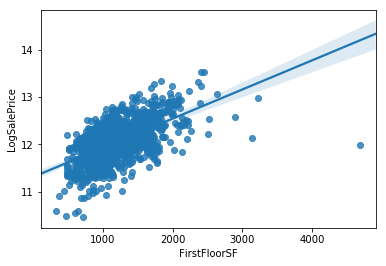

In [87]:
sns.regplot(df['FirstFloorSF'],df.LogSalePrice)

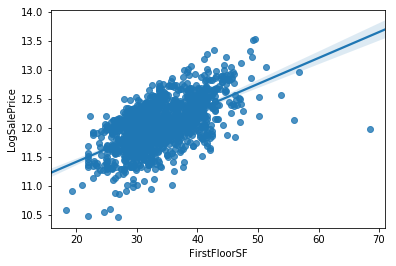

In [89]:
sns.regplot(np.sqrt(df['FirstFloorSF']),df.LogSalePrice)

In [90]:
df['FirstFloorSF_Sqrt'] = np.sqrt(df['FirstFloorSF'])

In [91]:
print('First Floor square feet vs Log Sale Price Correlation\n',df[['FirstFloorSF','LogSalePrice']].corr())
print('First Floor square feet vs Log Sale Price Correlation\n',df[['FirstFloorSF_Sqrt','LogSalePrice']].corr())

First Floor square feet vs Log Sale Price Correlation
               FirstFloorSF  LogSalePrice
FirstFloorSF      1.000000      0.596981
LogSalePrice      0.596981      1.000000
First Floor square feet vs Log Sale Price Correlation
                    FirstFloorSF_Sqrt  LogSalePrice
FirstFloorSF_Sqrt            1.00000       0.60872
LogSalePrice                 0.60872       1.00000


Slightly higher correlation for the square of 1st floor square feet so we will use that

In [94]:
df.drop('FirstFloorSF',axis=1,inplace=True)

### Above grade (ground) living area square feet

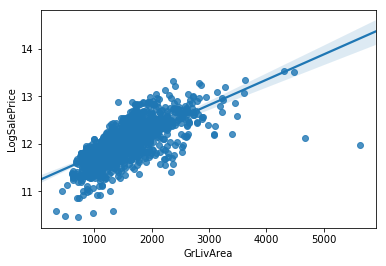

In [95]:
sns.regplot(df.GrLivArea,df.LogSalePrice)

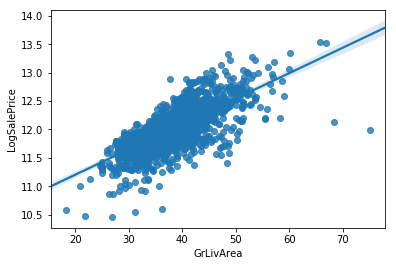

In [96]:
sns.regplot(np.sqrt(df.GrLivArea),df.LogSalePrice)

In [99]:
df['GrLivArea_Sqrt'] = np.sqrt(df['GrLivArea'])

In [102]:
print('Above grade (ground) living area square feet vs '+
      'Log Sale Price Correlation\n',
      df[['GrLivArea','LogSalePrice']].corr())
print('Above grade (ground) living area square feet Square Root '+
      'vs Log Sale Price Correlation\n',
      df[['GrLivArea_Sqrt','LogSalePrice']].corr())

Above grade (ground) living area square feet vs Log Sale Price Correlation
               GrLivArea  LogSalePrice
GrLivArea      1.000000      0.700927
LogSalePrice   0.700927      1.000000
Above grade (ground) living area square feet Square Root vs Log Sale Price Correlation
                 GrLivArea_Sqrt  LogSalePrice
GrLivArea_Sqrt        1.000000      0.722693
LogSalePrice          0.722693      1.000000


Slightly higher correlation for the square root of "Above grade (ground) living area square feet" so we will use that

In [103]:
df.drop('GrLivArea',axis=1,inplace=True)

### Year Built

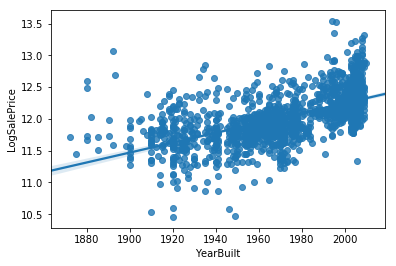

In [105]:
sns.regplot(df.YearBuilt,df.LogSalePrice)

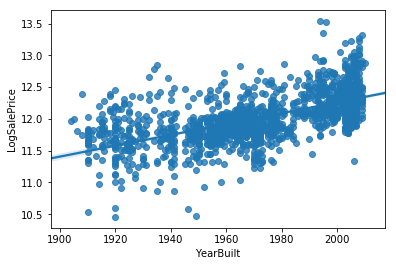

In [107]:
sns.regplot(df[df.YearBuilt>1900].YearBuilt,
            df[df.YearBuilt>1900].LogSalePrice)

In [115]:
print('Correlation with Houses Built Before 1900:\n',
      df[['YearBuilt','LogSalePrice']].corr(),'\n')
print('Correlation without Houses Built Before 1900:\n',
      df[df.YearBuilt>1900][['YearBuilt','LogSalePrice']].corr())

Correlation with Houses Built Before 1900:
               YearBuilt  LogSalePrice
YearBuilt       1.00000       0.58657
LogSalePrice    0.58657       1.00000 

Correlation without Houses Built Before 1900:
               YearBuilt  LogSalePrice
YearBuilt      1.000000      0.611296
LogSalePrice   0.611296      1.000000


Not a big enough increase to justify removing those outliers

### Train-Test Split

In [145]:
from sklearn.model_selection import train_test_split

In [157]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('LogSalePrice',axis=1),
                                                    df.LogSalePrice,
                                                    test_size=0.4,
                                                    random_state=0
                                                   ) 

In [164]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train,y_train)

0.82753066752844551

In [165]:
lr.score(X_test,y_test)

0.79441560956964485

Slightly lower score for our test model